In [1]:
#%% solve the Helmoltz equation with Soft-constrain DNN
# weakly & soft constraint
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import qmc
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import os
from tqdm import trange
import csv

## Environment preparing
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_dtype(torch.float64)

plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 100

seed = 1234
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Get Network

In [2]:
class Swish(nn.Module):
		def __init__(self, inplace=True):
			super(Swish, self).__init__()
			self.inplace = inplace

		def forward(self, x):
			if self.inplace:
				x.mul_(torch.sigmoid(x))
				return x
			else:
				return x * torch.sigmoid(x)

class ResBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,stride=1,padding=1):
        super(ResBlock,self).__init__()
        self.identity = nn.Identity()
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()
        self.linear = nn.Linear(in_channels,out_channels)
    
    def forward(self,x):
        identity = self.identity(x)
        out = self.linear(x)
        out += identity
        out = self.silu(out)
        return out

In [3]:
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        self.hc1 = nn.Linear(hidden_size, hidden_size)
        self.hc2 = nn.Linear(hidden_size, hidden_size)
        self.hc3 = nn.Linear(hidden_size, hidden_size)
        self.hc4 = nn.Linear(hidden_size, hidden_size)
        self.hc5 = nn.Linear(hidden_size, hidden_size)
        self.hc6 = nn.Linear(hidden_size, hidden_size)
        self.hc7 = nn.Linear(hidden_size, hidden_size)

        self.relu = nn.ReLU()
        self.silu = nn.SiLU()
        self.tanh = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(input_size)
        self.drop = nn.Dropout(p=0.05)
        self.resblock = ResBlock(hidden_size,hidden_size)
        self.swish = Swish()
        
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc3.weight)
        nn.init.kaiming_uniform_(self.hc1.weight)
        nn.init.kaiming_uniform_(self.hc2.weight)
        nn.init.kaiming_uniform_(self.hc3.weight)
        nn.init.kaiming_uniform_(self.hc4.weight)
        nn.init.kaiming_uniform_(self.hc5.weight)
        nn.init.kaiming_uniform_(self.hc6.weight)
        nn.init.kaiming_uniform_(self.hc7.weight)
        
    def forward(self, x):
        #out = self.bn1(x)
        out = self.fc1(x)
        out = self.silu(out)
        out = self.hc1(out)
        out = self.silu(out)
        #out = self.resblock(out)
        out = self.hc2(out)
        out = self.silu(out)
        #out = self.fc2(out)
        #out = self.swish(out)
        out = self.hc3(out)
        out = self.silu(out)
        out = self.hc4(out)
        out = self.silu(out)
        out = self.hc5(out)
        out = self.silu(out)
        out = self.hc6(out)
        out = self.silu(out)
        out = self.hc7(out)
        out = self.silu(out)
        #out = self.resblock(out)
        out = self.fc3(out)
        return out
    '''
    def forward(self, x):
        #out = self.bn1(x)
        out = self.fc1(x)
        out = self.relu(out)
        #out = self.fc2(out)
        #out = self.silu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.resblock(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.resblock(out)
        #out = self.fc2(out)
        #out = self.silu(out)
        out = self.fc3(out)
        return out'''

In [4]:
# define loss equation
Rscale = 25
Rbias = 35
Zscale = 50
Zbias = 50
Ksacle = 0.01
Kbias = 1.26
k = 2*np.pi*300/1500

def wmse_loss(output,true,weight):
    mse_loss = torch.nn.functional.mse_loss(output,true)
    return torch.mean(weight*mse_loss)

def loss_equation(model,X_ij):
    # assume grad_grad_al_ij -> a_rr a_rz a_zr a_zz
    # q_ij is Non-homogeneous term
    y_ij = model(X_ij)
    y_ij_grad = torch.autograd.grad(
        y_ij,X_ij,
        grad_outputs=torch.ones_like(y_ij),
        retain_graph=True,
        create_graph=True
    )[0] # yre_x yre_z yre_k

    yx_ij = y_ij_grad[:,0:1]
    yz_ij = y_ij_grad[:,1:2]
    y_drdX = torch.autograd.grad(
        yx_ij,X_ij,
        grad_outputs=torch.ones_like(yx_ij),
        retain_graph=True,
        create_graph=True
    )[0] # y_rr y_rz y_rk
    y_dzdX = torch.autograd.grad(
        yz_ij,X_ij,
        grad_outputs=torch.ones_like(yz_ij),
        retain_graph=True,
        create_graph=True
    )[0] # y_zr y_zz y_zk
    yxx_ij= y_drdX[:,0:1] # y_rr_r
    yzz_ij = y_dzdX[:,1:2] # y_zz_r
    # print(yrr_ij_r)
    tilde_p_rr =yxx_ij/(Rscale**2) # a_rr + 2b_ry_r + b_rr + y_rr
    tilde_p_r = 1/((X_ij[:,0:1]+Rbias)*Rscale)*(yx_ij/Rscale) # (a_r + b_r y + y_r b)/r
    tilde_p_zz = yzz_ij/(Zscale**2)     # a_zz + 2b_z y_z + y_zz b + b_zz y
    tilde_p = y_ij
    loss_eq = torch.nn.functional.mse_loss((tilde_p_rr + tilde_p_r + tilde_p_zz + k**2*tilde_p)**2,torch.zeros_like(y_ij))
    return loss_eq

def loss_Neuman(model,X_bd,Normal_bd):
    # X_ij = [vec(r),vec(z)] in tensor[N,2]
    # Normal_ij means the normal vector of boundary
    # pn_ij: true value in boundary; be_ij/grad_be_ij/grad_al_ij: constuct function/its grad
    y_ij = model(X_bd)
    y_ij_grad = torch.autograd.grad(
        y_ij,X_bd,
        grad_outputs=torch.ones_like(y_ij),
        retain_graph=True,
        create_graph=True
    )[0]
    yx_ij = y_ij_grad[:,0:1]
    yz_ij = y_ij_grad[:,1:2]

    normal_r = Normal_bd[:,0:1]
    normal_z = Normal_bd[:,1:2]

    #tilde_p_ne = normal_r*((yr_ij_r*be_ij + grad_be_ij[:,0:1]*y_ij_r)+grad_al_ij[:,0:1]) + \
    #    normal_z*((yz_ij_r*be_ij + grad_be_ij[:,1:2]) + grad_al_ij[:,1:2])
    tilde_p_ne = normal_r * yx_ij / Rscale - normal_z * yz_ij / Zscale # only need consider network partial
    p_ne_true = 0.0 * torch.ones_like(tilde_p_ne)
    loss_Ne = torch.nn.functional.mse_loss(tilde_p_ne,p_ne_true)
    return loss_Ne

def loss_dir(model,X_dir):
    output = model(X_dir)
    return torch.nn.functional.mse_loss(output,torch.zeros_like(output))

def loss_data(model,X_tr,p_tr):
    output = model(X_tr)
    #weight = torch.exp(-abs(p_true))
    #return wmse_loss(output,p_true,weight)
    return torch.nn.functional.mse_loss(output,p_tr)
    #return torch.nn.functional.mse_loss(output,p_tr)

def loss_total(p_tr,model,X_ij,X_tr,X_bd,X_dir,Normal_ij):
    ld = loss_data(model,X_tr,p_tr)
    #ln = loss_Neuman(model,X_bd,Normal_ij)
    ldr = loss_dir(model,X_dir)
    lq = loss_equation(model,X_ij)
    return ld+lq/10+ldr/10,ld,lq,ldr

### function for boundary

In [5]:
p0 = 1
H = 100
c = 1500
f = 300
# k = 2*np.pi*f/c
def Normal_vec(r,z,k):
    N_r = 0.0*r
    N_z = 1.0*np.ones_like(r)
    return np.hstack([N_r,N_z])
def k_z(r,z):
    z1 = 15
    z2 = 35
    c1 = [1520,1515.5,1485.5,1482.25]
    k_z = []
    for zz in z:
        if zz < z1:
            k_z.append(f*2*np.pi/((zz*(c1[1]-c1[0])/z1+c1[0])))
        if np.logical_and(zz >= z1 , zz<z2):
            k_z.append(f*2*np.pi/((zz-z1)*(c1[2]-c1[1])/(z2-z1)+c1[1]))
        if zz >= z2:
            k_z.append(f*2*np.pi/((zz-z2)*(c1[3]-c1[2])/(H-z2)+c1[2]))
    return k_z


In [7]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

rangeR = 100
rangeZ = 201
r_d = pd.read_csv('minp2w_10_60_300_r.csv')['r']
r_d = torch.tensor(r_d).reshape(-1,1)
z_d = pd.read_csv('minp2w_10_60_300_z.csv')['z']
z_d = torch.tensor(z_d).reshape(-1,1)
r,z = np.meshgrid(r_d[0:rangeR], z_d[0:rangeZ])
r = r.reshape((rangeR)*(rangeZ),1)
z = z.reshape((rangeR)*(rangeZ),1)

# Get boundary data
r_bd = r_d[0:rangeR]
z_bd = np.ones_like(r_bd)*(rangeZ-1)
# Get dir data
r_dir = r_d[0:rangeR]
z_dir = np.zeros_like(r_dir)

In [9]:
# Get scaled input
r = (r-Rbias)/Rscale
z = (z-Zbias)/Zscale
X_ij = np.hstack([r,z]) # [[r[0:199],0],[r[0:199],1],...,]
X_ij = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)

r_bd = (r_bd-Rbias)/Rscale
z_bd = (z_bd-Zbias)/Zscale
X_bd = np.hstack([r_bd,z_bd])
X_bd = torch.from_numpy(X_bd).requires_grad_(True).double().to(device)
norm_vec_bd = Normal_vec(r_bd,z_bd,k)
norm_vec_bd = torch.from_numpy(norm_vec_bd).double().to(device)

r_dir = (r_dir-Rbias)/Rscale
z_dir = (z_dir-Zbias)/Zscale
X_dir = np.hstack([r_dir,z_dir])
X_dir = torch.from_numpy(X_dir).requires_grad_(True).double().to(device)

# Get training data
rangeZ_d = 21
rangeR_d = 50
r_train = pd.read_csv('minp1k_10_60_300_r.csv')['r']
r_train = torch.tensor(r_train).reshape(-1,1)
z_train = pd.read_csv('minp1k_10_60_300_z.csv')['z']
z_train = torch.tensor(z_train).reshape(-1,1)
#r_train = torch.tensor([[10.0], [10.20408], [19.79592] ,[20]])
r_tr,z_tr = np.meshgrid(r_train[0:rangeR_d], z_train[1:rangeZ_d])
#r_tr,z_tr = np.meshgrid(r_train, z_train[1:rangeZ_d])
r_tr = r_tr.reshape((rangeR_d)*(rangeZ_d-1),1)
z_tr = z_tr.reshape((rangeR_d)*(rangeZ_d-1),1)
r_tr = (r_tr-Rbias)/Rscale
z_tr = (z_tr-Zbias)/Zscale
X_tr = np.hstack([r_tr,z_tr])
X_tr = torch.from_numpy(X_tr).requires_grad_(True).double().to(device)

l = list(np.linspace(0, 1, rangeR_d))
pr_train = pd.read_csv('minp1k_10_60_300_pr.csv',names=l)[l].values*3
pr_tr = pr_train[1:rangeZ_d,0:rangeR_d]
#pr_tr1 = pr_train[1:rangeZ_d,0:2]
#pr_tr1 = pr_tr1.reshape((2)*(rangeZ_d-1),1)
#pr_tr2 = pr_train[1:rangeZ_d,48:50]
#pr_tr2 = pr_tr2.reshape((2)*(rangeZ_d-1),1)
#pr_tr = np.concatenate((pr_tr1,pr_tr2),axis=1)
pr_tr = pr_tr.reshape((rangeR_d)*(rangeZ_d-1),1)
pr_tr = torch.from_numpy(pr_tr).double().to(device)

In [13]:
pr_tr.numpy().reshape((rangeR_d, rangeZ_d - 1)).mean()

0.0015421122360000012

### Training

In [ ]:
model_pr = FNN(2,20,1).to(device)
optimizer_r = torch.optim.Adam(
    list(model_pr.parameters()),
    lr = 1e-3
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_r,mode='min',factor=0.1,patience=10)
max_iter = 800000
def lr_adjust(step, optimizer: torch.optim.Adam):
    update_lr_1 = 1000
    update_lr_2 = 2000
    update_lr_3 = 3000
    update_lr_4 = 10000
    update_lr_5 = 20000
    update_lr_6 = 40000
    update_lr_7 = 100000
    if step == update_lr_1:
        for g in optimizer.param_groups:
            g['lr'] = 3e-4
    if step == update_lr_2:
        for g in optimizer.param_groups:
            g['lr'] = 1e-4
    if step == update_lr_3:
        for g in optimizer.param_groups:
            g['lr'] = 1e-4
    if step == update_lr_4:
        for g in optimizer.param_groups:
            g['lr'] = 5e-5
    if step == update_lr_5:
        for g in optimizer.param_groups:
            g['lr'] = 3e-5
    if step == update_lr_6:
        for g in optimizer.param_groups:
            g['lr'] = 1e-5
    if step == update_lr_7:
        for g in optimizer.param_groups:
            g['lr'] = 1e-6

In [ ]:
#x_train = X_ij#torch.randn(1000, 2)
#y_train = pd_r_ij
#y_train = torch.randn(400, 1).to(device)
#X_tr = torch.randn(400, 3).to(device)
loss_hist_r = []
pbar = trange(max_iter)
for step in pbar:
    lr_adjust(step, optimizer_r)
    optimizer_r.zero_grad()
    # outputs = model_pr(X_ij)
    loss,ld,lq,ldr = loss_total(pr_tr,model_pr,X_ij,X_tr,X_bd,X_dir,norm_vec_bd)
    loss.backward()
    optimizer_r.step()
    if step % 1 == 0:
        pbar.set_postfix({
            'loss': '{0:.5e}'.format(loss.item()),
            #'loss_Ne': '{0:.5e}'.format(ln.item()),
            'loss_res': '{0:.5e}'.format(ld.item()),
            'loss_eq': '{0:.5e}'.format(lq.item()),
            'loss_dir': '{0:.5e}'.format(ldr.item()),
            'stepsize': '{0:.5e}'.format(optimizer_r.param_groups[0]['lr']),
            'grad':'{0:.5e}'.format(torch.mean(model_pr.fc3.weight).item())
        })
        #print()
    loss_hist_r.append(loss.item())

 79%|███████▉  | 631170/800000 [16:34:52<4:34:15, 10.26it/s, loss=4.81828e-05, loss_res=2.30133e-05, loss_eq=2.42618e-04, loss_dir=9.07671e-06, stepsize=1.00000e-06, grad=3.63804e-02] 

KeyboardInterrupt: 

 79%|███████▉  | 631170/800000 [16:35:07<4:34:15, 10.26it/s, loss=4.81828e-05, loss_res=2.30133e-05, loss_eq=2.42618e-04, loss_dir=9.07671e-06, stepsize=1.00000e-06, grad=3.63804e-02]

### Training

### 训练结果

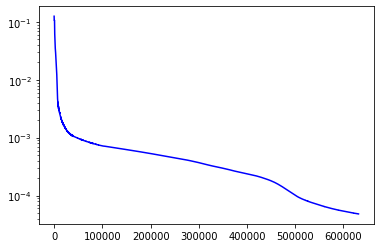

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_hist_r, 'b')
ax.set_yscale('log')
plt.show()

Text(0.5, 1.0, 'test data')

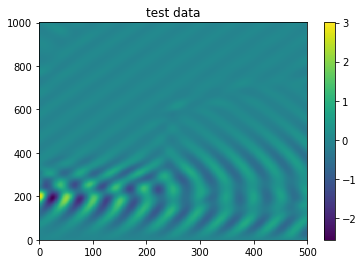

In [ ]:
rangeR_t = 500
rangeZ_t = 1001
r_d = pd.read_csv('../data/minp50w_10_60_300_r.csv')['r']
r_d = torch.tensor(r_d).reshape(-1,1)
z_d = pd.read_csv('../data/minp50w_10_60_300_z.csv')['z']
z_d = torch.tensor(z_d).reshape(-1,1)
r,z = np.meshgrid(r_d[0:rangeR_t], z_d[0:rangeZ_t])
r = r.reshape((rangeR_t)*(rangeZ_t),1)
z = z.reshape((rangeR_t)*(rangeZ_t),1)
r = (r-Rbias)/Rscale
z = (z-Zbias)/Zscale
X_te = np.hstack([r,z]) # [[r[0:199],0],[r[0:199],1],...,]
X_te = torch.from_numpy(X_te).requires_grad_(True).double().to(device)

output_test = (model_pr(X_te)).cpu().detach().numpy().reshape(rangeZ_t,rangeR_t)
plt.pcolor(output_test)
plt.colorbar()
plt.title('test data')
#plt.plot(pr_tr)

Text(0.5, 1.0, 'grad_truth')

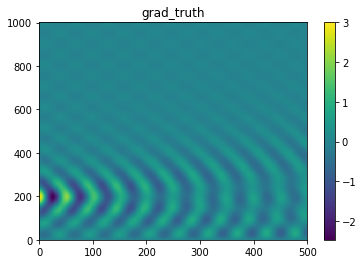

In [ ]:
l = list(np.linspace(0, 1, rangeR_t))
pr_test = pd.read_csv('../data/minp50w_10_60_300_pr.csv',names=l)[l].values*3
pr_te = pr_test[0:rangeZ_t,0:rangeR_t]
plt.pcolor(pr_te)
plt.colorbar()
plt.title('grad_truth')

error_mean 0.09541667397180584
grand_truth_mean 0.1910332964043416


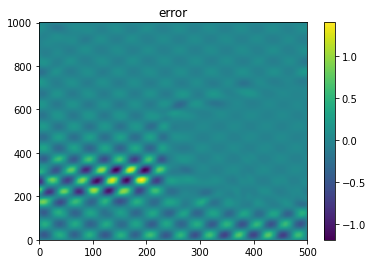

In [ ]:
plt.pcolor(pr_te-output_test)
plt.colorbar()
plt.title('error')
print('error_mean',np.mean(np.abs(pr_te-output_test)))
print('grand_truth_mean',np.mean(np.abs(pr_te)))

In [ ]:
# store the model
#torch.save(model_pr.state_dict(),os.path.join('../model','deepsmall_wv_10_110_smallgrid.pth'))
with open(os.path.join('../model','deepsmall_wv_10_110_epoch_loss_smallgrid.txt'),'a') as f:
    f.write(str(loss_hist_r))
    f.write('\n')

In [ ]:
# 加载模型参数
'''
state_dict = torch.load('../model/small_wv_10_20.pth',map_location=torch.device('cpu'))
model_pr = FNN(2,20,1)
model_pr.load_state_dict(state_dict)
output = model_pr(X_bd)

grad = torch.autograd.grad(
        output,X_bd,
        grad_outputs=torch.ones_like(output),
        retain_graph=True,
        create_graph=True
    )[0]
yz = grad[:,1:2]
#print(yz)
print(output)'''